In [98]:
from web3 import Web3, utils
from indexing_functions import * #indexing_functions.py
from configparser import ConfigParser
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

config = ConfigParser()
config.read('../config.ini')
etherscan_api = str(config.get('ETHERSCAN','etherscan_api'))

In [49]:
chain_list = {
    'Ethereum': {
        'uniswap_v3': '0xE592427A0AEce92De3Edee1F18E0157C05861564' #SwapRouter 0x68b3465833fb72A70ecDF485E0e4C7bD8665Fc45 #SwapRouter 2 same for all
        ,'erc20': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48' #USDC
    }
    ,'Arbitrum': {
        'uniswap_v3': '0xE592427A0AEce92De3Edee1F18E0157C05861564' #SwapRouter
        ,'erc20': '0xff970a61a04b1ca14834a43f5de4533ebddb5cc8' #USDC
    }
    ,'Optimism': {
        'uniswap_v3': '0xE592427A0AEce92De3Edee1F18E0157C05861564' #SwapRouter
        ,'erc20': '0x7f5c764cbc14f9669b88837ca1490cca17c31607', #USDC
    }
}

In [50]:
#print(chain_list)
chain_blocktimes = pd.DataFrame()
chain_transaction_data = pd.DataFrame()

for chain in chain_list:
    #set the right endpoint
    endpoint = config.get('ENDPOINTS',str.lower(chain))
    w3 = Web3(Web3.HTTPProvider(endpoint))
    temp_txs = pd.DataFrame()
    #get time range - last 24 hours
    end_blocktime = datetime.fromtimestamp( int(get_latest_block_info(chain)['result']['timestamp'], base =16) )
    start_blocktime =  end_blocktime - timedelta(hours = 24)
    # convert time range to block range
    end_block_number = int(get_latest_block(chain), base=16)
    start_block_number = get_block_by_timestamp(round(start_blocktime.timestamp()), chain)

    #Iterate through chains
    for contract in chain_list[chain]:
        input_contract = chain_list[chain][contract]
        #print(input_contract)
        result_txs = get_address_transactions_by_block_range(start_block_number,end_block_number,input_contract, chain)
        #print(result_txs)
        temp_txs = pd.DataFrame(result_txs)
        temp_txs = temp_txs[temp_txs['txreceipt_status'] == '1'] #only finalized txs
        # grab erc20 transfers only - by methodid
        if contract == 'erc20': 
                temp_txs = temp_txs[temp_txs['input'].str[0:10] == '0xa9059cbb']
                
        transactions = pd.DataFrame(temp_txs[['hash','timeStamp']])
        # assign group segments
        transactions['chain'] = chain
        transactions['tx_type'] = contract
    #iterrate to calculate transaction fees
    # Ethereum: Etherscan gas price x gas used
    # L2s - Need to call web3 since there are specialized fields
        for index, row in transactions.iterrows(): 
            if chain == 'Ethereum':
                transactions.loc[index, 'tx_fee'] = \
                    pd.to_numeric(temp_txs.loc[index,'gasPrice']) * pd.to_numeric(temp_txs.loc[index,'gas'])
            else:
                tx_receipt = w3.eth.get_transaction_receipt(row['hash'])
                gas_price = w3.eth.get_transaction(row['hash'])['gasPrice']
                if chain == 'Optimism':
                    tx_fee = Web3.toInt(hexstr=tx_receipt['l1Fee']) +\
                                    tx_receipt['gasUsed'] * gas_price
                elif chain == 'Arbitrum':
                    tx_fee = tx_receipt['effectiveGasPrice']*tx_receipt['gasUsed']
                # Assign tx fee back to transactions
                transactions.loc[index, 'tx_fee'] = tx_fee
           
        print(transactions)    
        chain_transaction_data = chain_transaction_data.append(transactions)


                                                   hash   timeStamp     chain  \
0     0xf8ef2d9cef80555e02f685c48ab6ed72b30471f1db36...  1642380434  Ethereum   
1     0x0585b2de05255ed68b5dd5b3a6cf1ee29a4f1223bf45...  1642380334  Ethereum   
2     0xf6e37836d8719afc7f50f404e499627e63176c79abee...  1642380328  Ethereum   
3     0x0046d5a604ab73cd102d631572585545f76f05d01b5c...  1642380328  Ethereum   
4     0x30652bc66495e7cc585219548ff7b660ad4ea837c07f...  1642380261  Ethereum   
...                                                 ...         ...       ...   
3267  0xa05ba12af43c5625e1561ad2cbfa857e8f158e0e9008...  1642294153  Ethereum   
3269  0xd1396f170e419d55c8758fea8ad94b77fc28a92b6150...  1642294117  Ethereum   
3270  0x7cb9439bba53c9c2e375d2491369ad77cf60b6e7739e...  1642294117  Ethereum   
3271  0xe4c595c18a4a8124a292e04dc782dd2ad197904e4f12...  1642294106  Ethereum   
3272  0x3808dc79d793e0d682150ce171052b4b4ca36c087dc8...  1642294025  Ethereum   

         tx_type        tx_

In [52]:
print(chain_transaction_data)
chain_transaction_data.to_csv('t24h_tx_fees.csv')

                                                  hash   timeStamp     chain  \
0    0xf8ef2d9cef80555e02f685c48ab6ed72b30471f1db36...  1642380434  Ethereum   
1    0x0585b2de05255ed68b5dd5b3a6cf1ee29a4f1223bf45...  1642380334  Ethereum   
2    0xf6e37836d8719afc7f50f404e499627e63176c79abee...  1642380328  Ethereum   
3    0x0046d5a604ab73cd102d631572585545f76f05d01b5c...  1642380328  Ethereum   
4    0x30652bc66495e7cc585219548ff7b660ad4ea837c07f...  1642380261  Ethereum   
..                                                 ...         ...       ...   
80   0xcb2bd8d1853ab7389be835cbd2a91e9d0a260338d78c...  1642347710  Optimism   
203  0x78828cce91bc16edc021223f6c96e702abde9d4095a2...  1642330677  Optimism   
248  0xa7fd1e640a427b2acdc4ed9d40ecf6f24dafc3940c7d...  1642321203  Optimism   
268  0x5150c08ac5b0f2331fce2efcef2291e1f11c80054144...  1642314096  Optimism   
297  0x8abdc631799849aa953215a045ca701b26e5504195bf...  1642301046  Optimism   

        tx_type        tx_fee  
0    un

In [57]:
chain_transaction_data['datetime'] = pd.to_datetime(chain_transaction_data['timeStamp'], unit = 's')
chain_transaction_data['tx_fee_eth'] = chain_transaction_data['tx_fee']/1e18
print(chain_transaction_data)                                             

                                                  hash   timeStamp     chain  \
0    0xf8ef2d9cef80555e02f685c48ab6ed72b30471f1db36...  1642380434  Ethereum   
1    0x0585b2de05255ed68b5dd5b3a6cf1ee29a4f1223bf45...  1642380334  Ethereum   
2    0xf6e37836d8719afc7f50f404e499627e63176c79abee...  1642380328  Ethereum   
3    0x0046d5a604ab73cd102d631572585545f76f05d01b5c...  1642380328  Ethereum   
4    0x30652bc66495e7cc585219548ff7b660ad4ea837c07f...  1642380261  Ethereum   
..                                                 ...         ...       ...   
80   0xcb2bd8d1853ab7389be835cbd2a91e9d0a260338d78c...  1642347710  Optimism   
203  0x78828cce91bc16edc021223f6c96e702abde9d4095a2...  1642330677  Optimism   
248  0xa7fd1e640a427b2acdc4ed9d40ecf6f24dafc3940c7d...  1642321203  Optimism   
268  0x5150c08ac5b0f2331fce2efcef2291e1f11c80054144...  1642314096  Optimism   
297  0x8abdc631799849aa953215a045ca701b26e5504195bf...  1642301046  Optimism   

        tx_type        tx_fee          

In [107]:
eth_api = 'https://api.coingecko.com/api/v3/simple/price?ids=ethereum&vs_currencies=usd' #coingecko
eth_price = requests.get(eth_api,headers=headers).json()['ethereum']['usd']

3323.3


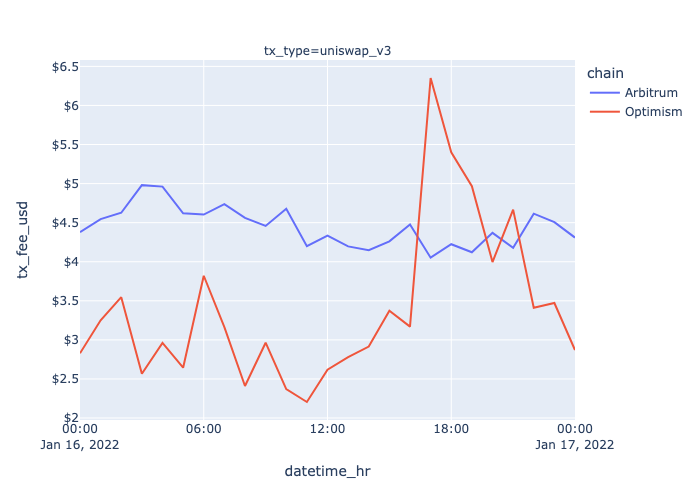

In [113]:
agg_fees = chain_transaction_data #copy
agg_fees['chain_tx_type'] = agg_fees['chain'] + ': ' + agg_fees['tx_type']
agg_fees['datetime_hr'] = agg_fees['datetime'].dt.floor('h')
agg_fees = agg_fees[['chain','tx_type','datetime_hr','tx_fee_eth']]
agg_fees = agg_fees.groupby( ['chain','tx_type','datetime_hr'] ).mean().reset_index()
agg_fees['tx_fee_usd'] = agg_fees['tx_fee_eth']*eth_price
# agg_fees = agg_fees[['chain', 'tx_type','datetime_hr','tx_fee_eth']]
# agg_fees = agg_fees.pivot(index = 'datetime_hr', columns = ["chain","tx_type"], values = 'tx_fee_eth')

agg_fees = agg_fees[agg_fees['chain'] != 'Ethereum']
swap_agg_fees = agg_fees[agg_fees['tx_type'] == 'uniswap_v3']

#at current eth price
fig = px.line(swap_agg_fees, x="datetime_hr", y="tx_fee_usd", color='chain', facet_col='tx_type')
fig.update_traces(hovertemplate=None)
fig.update_layout(yaxis_tickprefix = '$', hovermode='x')
fig.show()
fig.show("png")

#agg_fees = agg_fees[['tx_fee_eth']]
#agg_fees.plot()